# Modelling, Simulation and Optimisation (MSO) Project

**Student Name:** Soham Sameer More<br/>
**Student ID:** x19149140<br/>
M.Sc. Data Analytics (Jan 2020)<br/>

<hr>

# Table of Contents

1. [Import Libraries](#1.-Import-Libraries)
2. [Time Conversion Functions](#2.-Time-Conversion-Functions)
3. [Global Variables](#3.-Global-Variables)
4. [Disruption Data](#4.-Disruption-Data)
5. [Random Delay/Disruption Generator](#5.-Random-Delay/Disruption-Generator)
6. [Classes](#6.-Important-Classes-used-in-this-Simulation)
    1. [Disruption Class](#6.1-Disruption-Class)
    2. [Signalling Block Class](#6.2-Signalling-Block-Class)
    3. [Train Class](#6.3-Train-Class)
7. [Function to run the Simulation](#7.-Function-to-run-the-Simulation)
8. [Functions to Print Disruption and Simulation Results](#8.-Functions-to-Print-Disruption-and-Simulation-Results)
9. [Part 1: Simulation](#9.-Part-1:-Simulation)
    1. [Verbose Simulation](#9.1-Verbose-Simulation)
    2. [Plot Distributions](#9.2-Plot-Distributions)
10. [Part 2: Optimisation](#10.-Part-2:-Optimization)
    1. [Hill Climbing Optimization Algorithm](#10.1-Hill-Climbing-Algorithm)
11. [Optimization Results](#11.-Optimization-Results)
    1. [Optimization without Random Delays](#11.1-Optimization-without-Random-Delays)
    2. [Optimization with Random Delays](#11.2-Optimization-with-Random-Delays)
12. [References](#References)

## Design Decisions

For the simulation in this project the SimPy Python library was considered. However, the basic Python control structures provided more freedom and control over the calculations of dynamic variables like Speed of the train, Acceleration of the train, Distance covered by the train. It provided a more accurate representation of the simulation and handled the disruption events and delays appropriately.

**_That is why instead of using SimPy basic Python control structures are used to implement this project._**

# 1. Import Libraries

In [65]:
# All the imports used in this file


import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm.notebook import tqdm

import plotly.express as px

###################
# BUG REQUIREMENT #
###################
# Used twice because of a bug in matplotlib =>

%matplotlib notebook
%matplotlib notebook


plt.style.use('seaborn-pastel')

import pandas as pd
import random

from random import seed
from random import gauss


# Set random seed:
seed(123)

# 2. Time Conversion Functions

In [66]:
## Functions used to convert seconds to Time (Hours : Minutes : Seconds ) format

def convert(seconds): 
    seconds = seconds + config['start_hour'] * 3600
    seconds = seconds % (24 * 3600) 
    hour = (seconds // 3600)
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%s:%02d:%02d" % (str(hour).zfill(2), minutes, seconds)

def convertDifference(seconds): 
    #seconds = seconds % (3600) 
    hour = (seconds // 3600)
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)

# 3. Global Variables 

These variables are used throughout the program and are used in all the calculations.

**reset_config** function is used to reset all the global variables.

In [67]:
config = {
    'blocks' : [],                 # List of signalling blocks
    'trains' : [],                 # List of trains
    'block_length' : 0,            # Length of a single signalling block
    'trains_count' : 0,            # Number of trains
    'blocks_count' : 0,            # Number of signalling blocks
    'track_length' : 0,            # Total track length in kilometers
    'track_length_meters' : 0,     # Total track length in meters
    'hours' : 0,                   # Hours of operation in a day 
    'minutes' : 0,                 # Minutes of operation in a day
    'seconds' : 0,                 # Seconds of operation in a day
    'start_hour' : 0,              # First train time (ex: 7 AM)
    'disruptions' : [],            # List of disruption events
    'train_interval' : 0,          # Seconds between 2 trains
    'time_unit' : 1,               # Run the simulation per second (1) or per one tenth of a second (0.1)
    'time_now' : 0,                # Current time in simulation
    'animate' : None,              # Used to store simulation animation object
}


def reset_config(trains_per_hour, blocks_count):
    global config
    config['blocks'] = []
    config['trains'] = []
    config['blocks_count'] = blocks_count
    config['track_length_km'] = 145                                     # Track length in kilometers
    config['track_length_meters'] = config['track_length_km'] * 1000    # Track length in meters
    config['hours'] = 15                 # 7 AM to 10 PM
    config['minutes'] = config['hours'] * 60
    config['seconds'] = config['minutes'] * 60
    config['trains_count'] = trains_per_hour * config['hours']
    config['start_hour'] = 7                                            # First train starts at 7:00 AM 
    config['block_length'] = config['track_length_meters'] / config['blocks_count']
    config['disruptions'] = []
    config['train_interval'] = config['seconds'] // config['trains_count']
    config['time_now'] = 0
    config['animate'] = None

# 4. Disruption Data

The **disruptions** dataframe contains the details of the type of disruption and the respective frequency, mean, and standard deviation. This data taken from the study by Yuxiang Yand et al [1] of the High Speed Trains in China. 



In [68]:


disruptions = pd.DataFrame()

disruptions['causes'] = ['HE', 'FBI', 'BW', 'ND', 'PI', 'VF', 'TPSF', 'DCSF', 'CSSF', 'LF', 'OP']
disruptions['description'] = ['Human Error', 'Foreign Body Invasion', 'Bad Weather', 'Natural Disaster', 'Passenger Influence', 'Vehicle Fault', 'Traction and Power Supply Fault', 'Dispatching and Control System Fault', 'Communication and Signal System Fault', 'Line Fault', 'Other Problems']
disruptions['frequency_percentage'] = [2.6, 14.86, 16.78, 1.73, 3.53, 13.99, 19.01, 22.11, 1.3, 3.72, 0.37]
disruptions['trains_delayed_percentage'] =  [4.13, 14.77, 27.69, 7.14, 3.45, 9.48, 13.87, 12.78, 1.96, 4.38, 0.33]
disruptions['standard_deviation'] = [29, 26, 50, 81, 13, 26, 26, 41, 17, 26, 9]
disruptions['mean'] = [102, 114, 166, 599, 45, 102, 91, 128, 37, 81, 28]

print(disruptions)

   causes                            description  frequency_percentage  \
0      HE                            Human Error                  2.60   
1     FBI                  Foreign Body Invasion                 14.86   
2      BW                            Bad Weather                 16.78   
3      ND                       Natural Disaster                  1.73   
4      PI                    Passenger Influence                  3.53   
5      VF                          Vehicle Fault                 13.99   
6    TPSF        Traction and Power Supply Fault                 19.01   
7    DCSF   Dispatching and Control System Fault                 22.11   
8    CSSF  Communication and Signal System Fault                  1.30   
9      LF                             Line Fault                  3.72   
10     OP                         Other Problems                  0.37   

    trains_delayed_percentage  standard_deviation  mean  
0                        4.13                  29   1

# 5. Random Delay/Disruption Generator

The **generate_disruptions** function generates random disruption and delays based on the data available in the above **disruptions** dataframe.

A Disruption object is generated for every disruptive event and is added to the global list config['disruptions'].

In [69]:
# generate delays due to disruption



def generate_disruptions():
    global config
    for index, row in disruptions.iterrows():
        if row['causes'] == 'HE':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 0
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        if row['causes'] == 'FBI':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 0
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        if row['causes'] == 'BW':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 40
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_all_blocks(delay_duration, speed_limit, cause, start_time)
                config['disruptions'].append(disruption)
        if row['causes'] == 'ND':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 20
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_all_blocks(delay_duration, speed_limit, cause, start_time)
                config['disruptions'].append(disruption)
        if row['causes'] == 'PI':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 20
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        if row['causes'] == 'VF':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 0
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        if row['causes'] == 'TPSF':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 50
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        if row['causes'] == 'DCSF':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 30
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        if row['causes'] == 'CSSF':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 60
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        if row['causes'] == 'LF':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 0
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        if row['causes'] == 'OP':
            if random.randint(0,10000) <= row['frequency_percentage']*100:
                trains_delayed = int(row['trains_delayed_percentage']/100 * config['trains_count'])
                delay_duration = trains_delayed * config['train_interval']
                speed_limit = 50
                cause = row['description']
                start_time = random.randint(0,config['seconds'])
                block = random.randint(0, config['blocks_count'] - 1)
                disruption = Disruption()
                disruption.disrupt_one_block(delay_duration, speed_limit, cause, start_time, block)
                config['disruptions'].append(disruption)
        
        #print(row['frequency_percentage'])
    



# 6. Important Classes used in this Simulation

# 6.1 Disruption Class

Every disruption event is represented by an object class. This **Disruption Class** is defined below.

Every disruption event (class) has methods like disrupt_all_blocks(), disrupt_one_block(), update_status(), manual_disruption(), is_active() and block_disruption().

In [70]:
class Disruption:
    global config
    
    def __init__(self):
        self.disruption_time = 0
        self.disruption_time_left = 0
        self.disruption_cause = ''
        self.disrupted_blocks = []
        self.speed_limit = 86.1
        self.disruption_active = 0
        self.disruption_start_time = 0
    
    def disrupt_all_blocks(self, duration, speed_limit, cause, start_time):
        for i in range(0, config['blocks_count']):
            self.disrupted_blocks.append(i)
        self.speed_limit = speed_limit
        self.disruption_cause = cause
        self.disruption_start_time = start_time
        self.disruption_time = duration
        self.disruption_time_left = duration
        
    def disrupt_one_block(self, duration, speed_limit, cause, start_time, block):
        self.disrupted_blocks.append(block)
        self.speed_limit = speed_limit
        self.disruption_cause = cause
        self.disruption_start_time = start_time
        self.disruption_time = duration
        self.disruption_time_left = duration
    
    def manual_disruption(self, duration, speed_limit, cause, start_time, block):
        self.disrupted_blocks.append(block)
        self.speed_limit = speed_limit
        self.disruption_cause = cause
        self.disruption_start_time = start_time
        self.disruption_time = duration
        self.disruption_time_left = duration
    
    def update_status(self, i):
        if self.disruption_time_left == 0 and self.disruption_active:
            self.disruption_active = 0
        if self.disruption_active:
            self.disruption_time_left = self.disruption_time_left - 1
        if self.disruption_start_time == i:
            self.disruption_active = 1
            return
        return
    
    def is_active(self):
        if self.active or self.disruption_time:
            return True
        else:
            return False
    
    def block_disruption(self, block):
        if self.disruption_active:
            if block in self.disrupted_blocks:
                return self.speed_limit
            else:
                return 86.1
        else:
            return 86.1                              # max speed limit
            


            
            

    





# 6.2 Signalling Block Class

This class is used to enable signalling functionality in the simulation. Every train occupies a single signalling block at any given time. 

This **Signalling Block Class** is defined below.

In [71]:
        

class Block:
    global config
    
    def __init__(self, identity):
        self.identifier = identity
        #print(self.identifier)
        #self.current_train = Train
        self.occupied = 0
        self.signal = 1
        self.signal_delay = 0
        self.train_enter_time = []
        self.train_left_time = []
       

    
    def free(self, i):
        self.occupied = 0
        self.signal_delay = 5 / config['time_unit']
        self.train_left_time.append(i * config['time_unit'])

    
    def update_status(self,i):
        #if signal delay then reduce by 1
        if self.signal_delay > 0:
            self.signal_delay = self.signal_delay - 1
            if self.signal_delay == 0:
                self.signal = 1  # Turn signal green
        return

    def occupy(self, i):
        self.occupied = 1
        self.signal = 0  # Turn signal red
        self.train_enter_time.append(i * config['time_unit'])
        
        
    def signal_green(self):
        if self.signal:
            return True
        else:
            return False


# 6.3 Train Class

This is the main class used to simulate the train behaviour. Every train object has attributes like current speed, maximum speed reached by a train, start delay, operational delay (delay due to disruptions), acceleration of the train, etc.

The methods in this class decide the speed, acceleration, if the train should brake or accelerate based on the number of free blocks ahead, any speed limits imposed due to disruption event.

In [72]:

class Train:
    

    global config
    
    
    def __init__(self, time, identity):
        
        self.identifier = identity
        
        #self.start_time = 0
        self.actual_start_time = 0
        self.delayed_start = 0
        self.end_time = 0
        self.running = 0  # is the train currently running
        self.time_delay = []
        self.scheduled_to_run = 0
        self.operational_delay = []
        self.operational_delay_flag = 0

        self.current_block = 0


        self.max_speed = 86.1
        self.acc = 0.76
        self.braking = 0.38
        self.emergency_braking = 2.5
        
        self.emergency_braking_flag = 0

        self.braking_distance = 0 

        self.total_distance_covered = 0
        self.distance_remaining_block = 0
        self.distance_remaining_total = 145000 #meters
        self.free_distance = 0

        self.speed = 0
        self.train_max_speed = 0
        self.target_speed = 0
        self.acceleration = 0
        self.acceleration_flag = 0
        self.start_time = time
        self.start_delay = gauss(90,35)
        if self.start_delay > 0:
            self.actual_start_time = self.start_time + int(self.start_delay)
            self.add_delay(self.start_delay)
        else:
            self.actual_start_time = self.start_time
        #self.start()
    
    
    
    ## Check block disruption and return the speed limit of the block
    def block_disruption_speed(self):
        speed_limits = []
        for disruption in config['disruptions']:
            speed_limits.append(disruption.block_disruption(self.current_block))
        speed_limits.append(self.max_speed)
        speed_limits = [disruption.block_disruption(self.current_block) for disruption in config['disruptions']]
        speed_limits.append(self.max_speed)  # If no disruptions in block, speed limit is 86.1 (max speed)
        #if self.current_block == 0:
        #    print(speed_limits)
        min_speed_limit = min(speed_limits)
        return min_speed_limit
        
        
            
    
    # Is the train start delayed
    def is_start_delayed(self):
        if self.delayed_start:
            return True
        else:
            return False
    
    # Does the train have operationl delays due to disruption
    def is_operational_delay(self):
        if self.operational_delay_flag:
            return True
        else:
            return False
    
    # Check if the train has reached the destination
    def reached_destination(self):
        if self.end_time:
            return True
        else:
            return False
    
    
    # Checks and updates speed and acceleration of the train
    def speed_controller(self):
        # Update the max speed the train has reached.
        if self.speed > self.train_max_speed:
            self.train_max_speed = self.speed
        # check speed and update the acceelaration parameters
        if self.acceleration_flag == -1 and self.target_speed > self.speed:
            self.reset_acceleration_speed()
        elif self.acceleration_flag == 1 and self.target_speed < self.speed and self.target_speed > 0:
            self.reset_acceleration_speed()
        else:
            self.speed = self.speed + self.acc_or_break() * config['time_unit']
        safe_speed = self.safe_speed()    
        if self.speed > safe_speed:
            self.target_speed = safe_speed
            if self.speed < 1.01 * safe_speed:
                self.reset_acceleration_speed()
            else:
                if self.speed > 1.1 * safe_speed:
                    self.activate_emergency_braking()
                else:
                    self.activate_braking()
            
        else:
            #if self.target_speed == self.speed:
            if self.target_speed == safe_speed:
                self.reset_acceleration_speed()
            else:
                self.target_speed = safe_speed
        #if self.current_block == 0:
        #    print(self.target_speed)
        return
    
    
    # Calculates safe speed of a train for braking based on the free distance and/or free blocks ahead
    
    def safe_speed(self):
        self.free_distance = self.distance_left_in_block() + self.free_blocks_ahead() * config['block_length']
        #if self.current_block == 0:
        #    print(self.free_distance)
        train_safe_speed = np.sqrt(2*self.free_distance*self.braking)  # Derived from s = v1*t + (1/2) * a * t**2
        
        if train_safe_speed > self.max_speed:
            train_safe_speed = self.max_speed

        block_speed_limit = self.block_disruption_speed()
        
        if train_safe_speed > block_speed_limit:
            if train_safe_speed:
                running_delay = (train_safe_speed - block_speed_limit) * config['time_unit'] / train_safe_speed
            else:
                running_delay = 0
            
            # If train has not started, add the operational delay to start delay of train. Otherwise add it to operational delay
            if self.current_block == 0 and self.total_distance_covered == 0 and block_speed_limit == 0:
                self.time_delay.append(running_delay)
            else:
                self.operational_delay.append(running_delay)
                self.operational_delay_flag = 1
                
            train_safe_speed = block_speed_limit
        return train_safe_speed
    
    def free_blocks_ahead(self):
        total_blocks = config['blocks_count']
        #print(total_blocks)
        free_blocks = 0
        for i in range(self.current_block+1, int(total_blocks)):
            if config['blocks'][i].signal_green():
                free_blocks = free_blocks + 1
            else:
                break
        #print(free_blocks)
        return free_blocks
        
    # Accelerates the train
    def activate_acceleration(self):
        self.acceleration = self.acc
        self.acceleration_flag = 1
    
    # Applies brakes of the train
    def activate_braking(self):
        self.acceleration = self.braking
        self.acceleration_flag = -1
    
    # Apply emergency brakes of the train
    def activate_emergency_braking(self):
        self.emergency_braking_flag = 1
        self.acceleration = self.emergency_braking
        self.acceleration_flag = -1
    
    
    # Reset the acceleration and speed of the train
    def reset_acceleration_speed(self):
        self.acceleration_flag = 0
        self.speed = self.target_speed
        self.target_speed = 0
        self.acceleration = 0
        self.braking_distance = 0
        self.emergency_braking_flag = 0
        return True
    
    # Decides whether to accelerate of break the train
    def acc_or_break(self):
        if not self.acceleration_flag and self.target_speed != self.speed:
            if self.target_speed > self.speed:
                self.acceleration_flag = 1
            elif self.target_speed > 0 and self.target_speed < self.speed:
                self.acceleration_flag = -1
        
        if self.target_speed > self.speed:
            self.activate_acceleration()
        elif self.target_speed < self.speed and self.target_speed > 0:
            if self.emergency_braking_flag:
                self.activate_emergency_braking()
            else:
                self.activate_braking()
        elif self.target_speed == self.speed:
            self.reset_acceleration_speed()
            return 0
        return self.acceleration*self.acceleration_flag

    
    # Updates train parameters every second of the simulation
    def update_status(self,i):
        
        config['blocks'][-1].signal = 0   ### Set the last extra block signal to red. This allows the train to brake at 145000 meters.
        
        if self.running:
            self.speed_controller()
            self.total_distance_covered = self.total_distance_covered + self.distance_covered()
            
            if self.total_distance_covered >= config['track_length_meters']:
                self.running = 0
                self.end_time = i * config['time_unit']
                self.speed = 0
                self.target_speed = 0
                self.reset_acceleration_speed()
                config['blocks'][-2].free(i * config['time_unit'])
            new_block = self.total_distance_covered // config['block_length']
            if int(new_block) != int(self.current_block):
                # Free block and occupy next
                config['blocks'][int(self.current_block)].free(i * config['time_unit'])
                config['blocks'][int(new_block)].occupy(i * config['time_unit'])
                self.current_block = int(new_block)
                
        elif self.actual_start_time == i* config['time_unit']:
            self.start(i* config['time_unit'])
        elif self.scheduled():
            self.start(i* config['time_unit'])
            
    def scheduled(self):
        if self.scheduled_to_run:
            return True
        else:
            return False
            
    # Start train and update the start time of train
    def start(self,i):
        if config['blocks'][0].signal_green():
            config['blocks'][0].occupy(i)
            self.running = 1
            self.target_speed = self.safe_speed()
            if self.target_speed == 0:
                self.scheduled_to_run = 1
                self.running = 0
                config['blocks'][0].free(i)
            elif self.scheduled_to_run == 1:
                self.delayed_start = i - self.actual_start_time
                self.time_delay.append(self.delayed_start)
                #self.operational_delay.append(self.delayed_start)
                self.actual_start_time = i
                self.scheduled_to_run = 0
        else:
            self.scheduled_to_run = 1
        return
        
    
    
    # Check the signal for block i
    def check_block_signal(self,i):
        if config['blocks'][i].signal == 1:
            return True
        else:
            return False
    
    # Check if block i is occupied
    def check_block_occupied(self,i):
        if config['blocks'][i].occupied == 0:
            return True
        else:
            return False
    
    
    # Adds delay to train
    def add_delay(self,time):
        self.time_delay.append(time)
    
    # Returns total delay of the train
    def total_start_delay(self):
        return sum(self.time_delay)
    
    # Returns current speed of the train
    def current_speed(self):
        return self.speed
    
    # Returns the required free blocks to maintain current speed
    def distance_left_in_block(self):
        distance_left_in_current_block = config['block_length'] - (self.total_distance_covered % config['block_length'])
        return distance_left_in_current_block
    
    # Distance covered in last second
    def distance_covered(self):
        #distance = self.speed * 1 + 0.5 * float(self.acc_or_break())  # * 1 * 1
        distance = self.speed * config['time_unit'] + 0.5 * float(self.acc_or_break())   * config['time_unit'] * config['time_unit']
        return distance
    
    # Returns if the train is running or not
    def is_running():
        if self.running:
            return True
        else:
            return False
    



# 7. Function to run the Simulation

Update the status of every Train, Block and Disruption event every second.

For loop is used to run the simulation for twice the operational time in a day. The loop is broken if the last train reached the desination.

In [73]:

def train_timetable(n,k):
    for i in range(0,int(config['seconds']*2/config['time_unit'])):
        config['time_now'] = i * config['time_unit']
        for disruption in config['disruptions']:
            disruption.update_status(i)
        for train in config['trains']:
            train.update_status(i)
        for block in config['blocks']:
            block.update_status(i)
        if config['trains'][-1].end_time != 0:    # Stop the loop if last train has reached.
            break
    return 'Simulation Complete'

# 8. Functions to Print Disruption and Simulation Results

**print_disruptions** function prints a list of all the disruptions in a simulation.

**get_simulation_report** returns all the metrics of the simulation. If the **print_report** parameter is set to **True**, the function prints the simulation metrics and the train time-table. If the **plot_distributions** parameter is set to **True**, the function prints histograms of a few key metrics in the simulation.

In [74]:

def print_disruptions():
    disruptions_heading = '''
+--------------------------------------+
|               DISRUPTIONS            |
+--------------------------------------+
    '''
    print(disruptions_heading)
    if len(config['disruptions']):
        for disruption in config['disruptions']:
            print('[#]  ' + str(disruption.disruption_cause) + ' caused a ' + str(disruption.disruption_time) + ' seconds delay at ' + str(convert(disruption.disruption_start_time)) + ' in block(s) ' + str(disruption.disrupted_blocks) + ' with a speed limit of ' + str(disruption.speed_limit) + ' m/s.')
    else:
        print('No random disruptions generated.')
        print('\n\n')

def get_simulation_report(print_report = False, plot_distributions = False):
    
    df = pd.DataFrame()
    
    actual_start_times = [train.actual_start_time for train in config['trains']]
    end_times = [train.end_time for train in config['trains']]

    TotalTime = pd.Series(end_times) - pd.Series(actual_start_times)

    df['Total Time Seconds'] = TotalTime
    df['Total Time'] = pd.Series(map(convertDifference, TotalTime))
    df['Start Times'] = pd.Series([train.start_time for train in config['trains']])
    df['Actual Start Times'] = pd.Series([train.actual_start_time for train in config['trains']])
    df['Dwell Time'] = df['Actual Start Times'] - df['Start Times']
    df['Average Speed'] = pd.Series(config['track_length_meters'] / df['Total Time Seconds'])
    df['Max Speed'] = pd.Series([train.train_max_speed for train in config['trains']])
    df['Distance Covered'] = pd.Series([train.total_distance_covered for train in config['trains']])
    df['Delayed'] = pd.Series([train.is_start_delayed() for train in config['trains']])
    df['Total Delay'] = pd.Series( [train.total_start_delay() for train in config['trains']])
    df['Travel Duration'] = pd.Series( [train.end_time - train.actual_start_time for train in config['trains']])
    df['Operational Delay'] = pd.Series( [sum(train.operational_delay) for train in config['trains']])
    df['Time Delay'] = pd.Series( [sum(train.time_delay) for train in config['trains']])

    
    average_delay = sum(df['Total Delay'])/len(df['Total Delay'])
    average_speed = sum(df['Average Speed'])/len(df['Average Speed'])
    percentage_trains_delayed = sum(df['Delayed'])/len(df['Delayed'])*100
    average_travel_time = sum(df['Total Time Seconds'])/len(df['Total Time Seconds'])
    total_operational_delay = sum(df['Operational Delay'])
    max_travel_time = max(df['Total Time Seconds'])
    max_speed = 86.1

    if print_report:
        simulation_heading = '''
+------------------------+
|   SIMULATION RESULTS   |
+------------------------+
        '''
        timetable_heading = '''
+------------------------+
|    TRAIN TIME TABLE    |
+------------------------+
        '''
        print(simulation_heading)
        print('Average Delay: ', end=' ')
        print('{:.2f}'.format(average_delay))
        print('Average Speed: ', end=' ')
        print('{:.2f}'.format(average_speed))
        print('Percentage Trains Delayed: ', end=' ')
        print('{:.2f}'.format(percentage_trains_delayed))
        print('Average Travel Time: ', end=' ')
        print('{:.2f}'.format(average_travel_time), end='  (')
        print(convertDifference(average_travel_time), end=')\n')
        print('Total Operational Delay: ', end=' ')
        print('{:.2f}'.format(total_operational_delay))
        print('Maximum Travel Time: ', end=' ')
        print('{:.2f}'.format(max_travel_time))
        print('\n\n')
        print(timetable_heading)
        print("----------------------------------------------------------------------------------------------")
        print("[Train Number] [Scheduled Departure] [Actual Departure] [Arrival Time] [Total Delay] [Delayed]")
        print("                     [London]                            [Birmingham]                           ")
        print("----------------------------------------------------------------------------------------------")
        for train in config['trains']:
            print("[Train {0}]    [{1}]            [{2}]         [{3}]      [{4}]   [{5}]".format(str(train.identifier).zfill(3),convert(train.start_time),convert(train.actual_start_time), convert(train.end_time), convertDifference(sum([sum(train.time_delay), sum(train.operational_delay)])), train.is_operational_delay() or train.is_start_delayed()))
        
        
        # Plot distributions here
    if plot_distributions:
        #df = px.data.tips()
        fig = px.histogram(df['Travel Duration'], x="Travel Duration", labels={
                                 "Travel Duration": "Travel Duration of Trains (seconds)"
                             },
                            title="Travel Duration Distribution",
                          )
        fig.show()
        fig = px.histogram(df['Average Speed'], x="Average Speed", labels={
                                 "Average Speed": "Average Speed m/s"
                             },
                            title="Average Speed Distribution",
                          )
        fig.show()
        fig = px.histogram(df['Dwell Time'], x="Dwell Time", labels={
                                 "Dwell Time": "Dwell Time (seconds)"
                             },
                            title="Dwell Time Distribution",
                          )
        fig.show()       
        
    return max_speed, average_delay, average_speed, percentage_trains_delayed, average_travel_time, total_operational_delay, max_travel_time
    

# 9. Part 1: Simulation


### Function : simulate_trains()

### Parameters :

- trains_per_hour : Input the trains running per hour
- signalling_blocks : Input the number of signalling blocks on the train line
- introduce_delays : Boolean. Introduce random disruptions and delays based on the study of Yuxiang Yand et al [1]
- custom_delay : Disruption Object. Used to introduce the the 30 mins disruption of the 9:00 AM train.
- print_disruption : Boolean. Verbose output of the disruptions.
- print_report : Boolean. Print the results of the simulation.
- plot_distributions : Boolean. Plot the distribution graphs.

In [75]:
def simulate_trains(trains_per_hour, signalling_blocks,  introduce_delays = False, custom_delay = None, print_disruption = True, print_report=True, plot_distributions = False):
    start_time = 0
    global config
    reset_config(trains_per_hour, signalling_blocks)
    
    if custom_delay:
        config['disruptions'].append(custom_delay)
    
    
    if introduce_delays:
        generate_disruptions()
    if print_disruption:
        print_disruptions()
        
    for i in range(0,signalling_blocks+1):
        config['blocks'].append(Block(i))
    for i in range(0,trains_per_hour*15+1):
        config['trains'].append(Train(start_time, i))
        start_time = start_time + config['train_interval']
    train_timetable(trains_per_hour,signalling_blocks)
    
    
    simulation_results = get_simulation_report(print_report, plot_distributions)
    return simulation_results


# 9.1 Verbose Simulation

Run a simulation with random disruptions. Also, introduce a 30 minutes delay at 9 AM. The train at 9 AM is delayed by 30 minutes. All the subsequent trains are afftected by the knock-on effect due to delay at 9 AM.

In [76]:
# Reset the global data
reset_config(10, 15)


# Introduce a 30 minutes delay at 9AM on first block.
breakdown = Disruption()
breakdown.manual_disruption(duration = 30*60, speed_limit = 0, cause = 'Electrical Malfunction', start_time = 3600 * (9-config['start_hour']), block = 0)
#config['disruptions'].append(breakdown)


# Run the simulation
return_data = simulate_trains(trains_per_hour = 10, signalling_blocks = 15, introduce_delays = True, custom_delay = breakdown, print_disruption = True, print_report=True, plot_distributions = False)


+--------------------------------------+
|               DISRUPTIONS            |
+--------------------------------------+
    
[#]  Electrical Malfunction caused a 1800 seconds delay at 09:00:00 in block(s) [0] with a speed limit of 0 m/s.
[#]  Bad Weather caused a 14760 seconds delay at 20:59:54 in block(s) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] with a speed limit of 40 m/s.
[#]  Vehicle Fault caused a 5040 seconds delay at 13:54:06 in block(s) [8] with a speed limit of 0 m/s.

+------------------------+
|   SIMULATION RESULTS   |
+------------------------+
        
Average Delay:  141.10
Average Speed:  71.59
Percentage Trains Delayed:  5.96
Average Travel Time:  2259.81  (0:37:39)
Total Operational Delay:  59668.40
Maximum Travel Time:  6825.00




+------------------------+
|    TRAIN TIME TABLE    |
+------------------------+
        
----------------------------------------------------------------------------------------------
[Train Number] [Scheduled Departure] [A

[Train 075]    [14:30:00]            [14:30:10]         [15:35:56]      [0:31:03]   [True]
[Train 076]    [14:36:00]            [14:37:29]         [15:35:46]      [0:25:12]   [True]
[Train 077]    [14:42:00]            [14:43:29]         [15:35:46]      [0:19:12]   [True]
[Train 078]    [14:48:00]            [14:48:59]         [15:35:56]      [0:12:59]   [True]
[Train 079]    [14:54:00]            [14:55:01]         [15:35:46]      [0:07:12]   [True]
[Train 080]    [15:00:00]            [15:01:26]         [15:40:30]      [0:01:26]   [False]
[Train 081]    [15:06:00]            [15:07:15]         [15:39:47]      [0:01:15]   [False]
[Train 082]    [15:12:00]            [15:14:19]         [15:44:19]      [0:02:19]   [False]
[Train 083]    [15:18:00]            [15:18:52]         [15:48:52]      [0:00:52]   [False]
[Train 084]    [15:24:00]            [15:24:58]         [15:54:58]      [0:00:58]   [False]
[Train 085]    [15:30:00]            [15:32:00]         [16:02:00]      [0:02:00]   [

# 9.2 Plot Distributions

While running the simulation, set the **plot_distributions** parameter to **True** to plot the distiutions of a few key metrics of the simulation.

In [77]:
# Reset global variables
reset_config(10, 15)

# Plot Distributions
return_data = simulate_trains(trains_per_hour = 10, signalling_blocks = 15,  introduce_delays = True, custom_delay = breakdown, print_disruption = True, print_report=False, plot_distributions = True)


+--------------------------------------+
|               DISRUPTIONS            |
+--------------------------------------+
    
[#]  Electrical Malfunction caused a 1800 seconds delay at 09:00:00 in block(s) [0] with a speed limit of 0 m/s.


# 10. Part 2: Optimization

### Objective Function

**Maximise** the number of trains running per hour.

**Constraint:** Delay time should not be more than half of the time interval between consecutive scheduled trains.


The objective function is calculated such that the objective function gives a higher output if the trains are not delayed. Also, higher the average speed of trains, better is the result of the objective function.

In case the delay in trains is more than half of the scheduled time between 2 consequtive trains, the objective function introduces a penalty of 0.5 which results in lower objective  score.

In [78]:
import numpy as np


def f(n, k, introduce_delays = False):
    results = simulate_trains(trains_per_hour = int(n), signalling_blocks = int(k), introduce_delays = False, custom_delay = None, print_disruption = False, print_report=False, plot_distributions = False)
    max_speed, average_delay, average_speed, percentage_trains_delayed, average_travel_time, total_operational_delay, max_travel_time = results

    
    if average_delay <= 0.5 * config['train_interval']:
        objective_func = n * (average_speed/max_speed) * (100 - percentage_trains_delayed) * n/(total_operational_delay+1)
    else:
        objective_func = n * (average_speed/max_speed) * (100 - percentage_trains_delayed) * n/(total_operational_delay+1) * 0.5 #0.5 is used as a delay penalty

    
    return objective_func




## 10.1 Hill Climbing Algorithm

Hill Climbing algorithm with a neighbourhood of **k=2** is used in this algorithm.



In [79]:



def neighbours(x, y, xmin, xmax, ymin, ymax, K=2):
    return \
        [ (x+i, y) for i in range(-K, K+1) \
            if i!=0 and xmin<=x+i and x+i<=xmax ] + \
        [ (x, y+i) for i in range(-K, K+1) \
            if i!=0 and ymin<=y+i and y+i<=ymax ] + \
        [ (x+i, y+i) for i in range(-K, K+1) \
            if i!=0 and xmin<=x+i and x+i<=xmax and ymin<=y+i and y+i<=ymax ] + \
        [ (x+i, y-i) for i in range(-K, K+1) \
            if i!=0 and xmin<=x+i and x+i<=xmax and ymin<=y-i and y-i<=ymax ]



def hill_climbing(nmin=1, nmax=10, kmin=1, kmax=10, introduce_delays = False):

    z = np.zeros(shape=(nmax+1 - nmin, kmax + 1 - kmin))
    x0 = random.randint(nmin, nmax)
    y0 = random.randint(kmin, kmax)

    xp = [ x0 ]
    yp = [ y0 ]
    fmax = f(x0, y0, introduce_delays)
    z[x0-1][y0-1] = fmax
    print("+------------------+")
    print("|    Optimising    |")
    print("+------------------+")
    print(f"{' n'} {' k'} {'f(n, k)':>9s}")
    print(f"{x0:2d} {y0:2d} {fmax:9.3f}")
    
    import time
    animation = "|/-\\"
    idx = 0
    while True:
        #print(z)
        xi = xp[-1]
        yi = yp[-1]
        fi = fmax
        #print(neighbours(xi, yi, nmin, nmax, kmin, kmax, 3))
        for xy in neighbours(xi, yi, nmin, nmax, kmin, kmax, 2):
            print(animation[idx % len(animation)], end="\r")
            idx += 1
            if xy!=None:
                x, y = xy
                if z[x-1][y-1]:
                    if z[x-1][y-1] > fi:
                        xi = x
                        yi = y
                        fi = z[x-1][y-1]
                else:
                    ff = f(x, y, introduce_delays)
                    z[x-1][y-1] = ff
                    if ff > fi:
                        xi = x
                        yi = y
                        fi = ff
        if fi == fmax:
            print('')
            break

        xp += [xi]
        yp += [yi]
        fmax = fi
        print(f"{xi:2d} {yi:2d} {fi:9.3f}")

    optimal_n = xp[-1] 
    optimal_k = yp[-1]
          
          
          
    # generate contour plot of f
    xs = np.linspace(nmin, nmax, nmax)
    ys = np.linspace(kmin, kmax, kmax)
    yy, xx = np.meshgrid(ys, xs)
    #z=f(xx, yy)
      
          
    print('\n\nPlotting Hill Climbing:')
    pbar = tqdm(total=(nmax)*(kmax))
    
    for n in range(nmin,nmax+1):
        #x = []
        for k in range(kmin, kmax+1):
            if not z[n-1][k-1]:
                z[n-1][k-1] = f(n,k)
            #x.append(int(f(n,k)))
            pbar.update(1)
        #z.append(x)
    pbar.close()
    Z = np.array(z)
    #print(z)      
          
          
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(8)
    fig.set_figheight(5)
    cs = ax.contourf(ys, xs, z, 100)
    fig.colorbar(cs, ax=ax)

    # display the points considered
    plt.scatter(yp, xp, c='red', marker='.')
    
    # overlay with the path choosen
    plt.plot(yp, xp, c='red', lw=1)
    
    optimal_solution_heading = simulation_heading = '''
+------------------------+
|    OPTIMAL SOLUTION    |
+------------------------+
'''
    print(optimal_solution_heading)
    
    print('Trains per hour: ' + str(optimal_n))
    print('Signalling blocks: ' + str(optimal_k))
    
    simulate_trains(trains_per_hour = int(optimal_n), signalling_blocks = int(optimal_k), introduce_delays = introduce_delays, custom_delay = None, print_disruption = introduce_delays, print_report=True, plot_distributions = False)
    
    return len(xp), xp[-1], yp[-1], z[xp[-1]-1][yp[-1]-1]




# 11. Optimization Results

In the optimization stage, a minimum of 1 train per hour and a maximum of 10 trains per hour are considered. Also, a minimum of 1 signalling block and a maximum of 15 signalling blocks are considered.

That is because, with 10 trains running per hour, the interval between 2 consequtive trains is 6 minutes. The random delays in the train start times due to passanger movement that are considered in this project have a **&mu; = 90 seconds** and **&sigma; = 35 seconds**. Sometimes the start deays extend upto 150 seconds which is almost half of the time interval between consecutive trains. If more than 10 trains per hour are considered, the time interval and start delays hinder the smooth functioning of the train simulation.

Also, with a miaximum of 15 signalling blocks on a 145000 meters stretch of track, each block is 9666.67 meters in length. That is not even 10 kilometers. If the signalling blocks are any shorter than 10 kilometers, it will hinder the trains from running at maximum speed over long distances.

## 11.1 Optimization without Random Delays



<font color=red size=3> **Note: Running the hill climbing algorithm takes a significant amount of time.**</font>

+------------------+
|    Optimising    |
+------------------+
 n  k   f(n, k)
 4  9  1496.967
 6  9  3368.177
 8 11  5984.789
10 13  9317.729
10 15  9337.248
\


Plotting Hill Climbing:


<IPython.core.display.Javascript object>


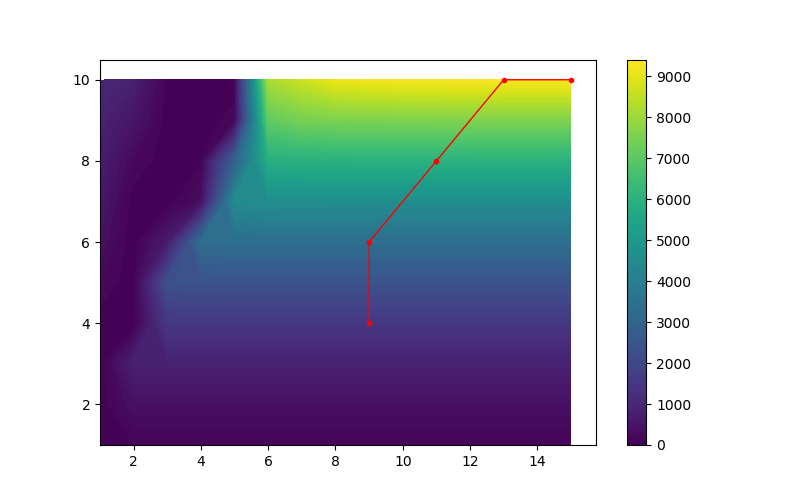


+------------------------+
|    OPTIMAL SOLUTION    |
+------------------------+

Trains per hour: 10
Signalling blocks: 15

+------------------------+
|   SIMULATION RESULTS   |
+------------------------+
        
Average Delay:  92.82
Average Speed:  80.35
Percentage Trains Delayed:  0.00
Average Travel Time:  1804.56  (0:30:04)
Total Operational Delay:  0.00
Maximum Travel Time:  1843.00




+------------------------+
|    TRAIN TIME TABLE    |
+------------------------+
        
----------------------------------------------------------------------------------------------
[Train Number] [Scheduled Departure] [Actual Departure] [Arrival Time] [Total Delay] [Delayed]
                     [London]                            [Birmingham]                           
----------------------------------------------------------------------------------------------
[Train 000]    [07:00:00]            [07:01:44]         [07:31:44]      [0:01:44]   [False]
[Train 001]    [07:06:00]            

[Train 079]    [14:54:00]            [14:55:51]         [15:25:51]      [0:01:51]   [False]
[Train 080]    [15:00:00]            [15:00:30]         [15:30:40]      [0:00:30]   [False]
[Train 081]    [15:06:00]            [15:06:53]         [15:36:53]      [0:00:53]   [False]
[Train 082]    [15:12:00]            [15:13:07]         [15:43:07]      [0:01:07]   [False]
[Train 083]    [15:18:00]            [15:19:39]         [15:49:39]      [0:01:39]   [False]
[Train 084]    [15:24:00]            [15:25:12]         [15:55:13]      [0:01:12]   [False]
[Train 085]    [15:30:00]            [15:32:56]         [16:02:56]      [0:02:56]   [False]
[Train 086]    [15:36:00]            [15:38:24]         [16:08:25]      [0:02:24]   [False]
[Train 087]    [15:42:00]            [15:44:39]         [16:14:39]      [0:02:39]   [False]
[Train 088]    [15:48:00]            [15:48:39]         [16:19:04]      [0:00:39]   [False]
[Train 089]    [15:54:00]            [15:56:23]         [16:26:23]      [0:02:23

(5, 10, 15, 9337.248325286926)

In [82]:
hill_climbing(1,10,1,15, introduce_delays = False)


## 11.2 Optimization with Random Delays



<font color=red size=3> **Note: Running the hill climbing algorithm takes a significant amount of time.**</font>

+------------------+
|    Optimising    |
+------------------+
 n  k   f(n, k)
 8  4    71.749
10  6  8300.787
10  8  9071.464
10 10  9260.506
10 12  9297.952
10 14  9322.979
10 15  9334.325
/


Plotting Hill Climbing:


<IPython.core.display.Javascript object>


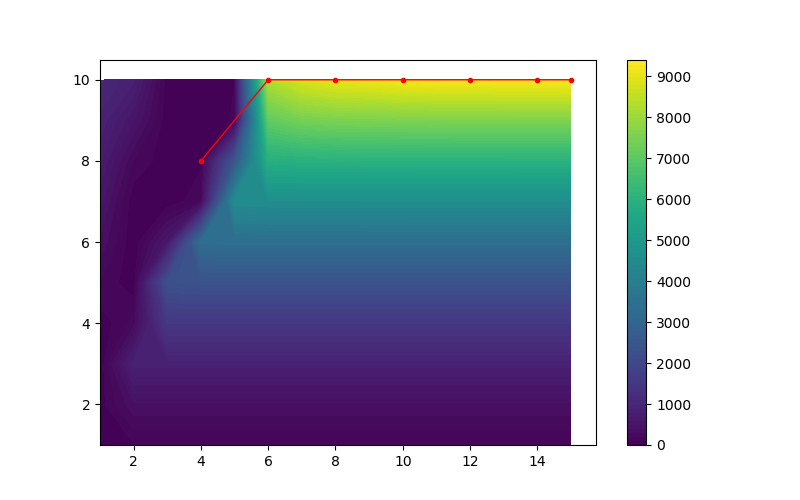


+------------------------+
|    OPTIMAL SOLUTION    |
+------------------------+

Trains per hour: 10
Signalling blocks: 15

+--------------------------------------+
|               DISRUPTIONS            |
+--------------------------------------+
    
[#]  Vehicle Fault caused a 5040 seconds delay at 08:00:10 in block(s) [9] with a speed limit of 0 m/s.
[#]  Dispatching and Control System Fault caused a 6840 seconds delay at 17:05:40 in block(s) [8] with a speed limit of 30 m/s.

+------------------------+
|   SIMULATION RESULTS   |
+------------------------+
        
Average Delay:  89.43
Average Speed:  75.04
Percentage Trains Delayed:  0.00
Average Travel Time:  2095.37  (0:34:55)
Total Operational Delay:  39429.63
Maximum Travel Time:  6804.00




+------------------------+
|    TRAIN TIME TABLE    |
+------------------------+
        
----------------------------------------------------------------------------------------------
[Train Number] [Scheduled Departure] [Actual Depart

[Train 075]    [14:30:00]            [14:30:43]         [15:00:51]      [0:00:43]   [False]
[Train 076]    [14:36:00]            [14:37:22]         [15:07:22]      [0:01:22]   [False]
[Train 077]    [14:42:00]            [14:43:13]         [15:13:13]      [0:01:13]   [False]
[Train 078]    [14:48:00]            [14:49:44]         [15:19:44]      [0:01:44]   [False]
[Train 079]    [14:54:00]            [14:54:45]         [15:24:50]      [0:00:45]   [False]
[Train 080]    [15:00:00]            [15:01:10]         [15:31:10]      [0:01:10]   [False]
[Train 081]    [15:06:00]            [15:07:27]         [15:37:27]      [0:01:27]   [False]
[Train 082]    [15:12:00]            [15:13:57]         [15:43:57]      [0:01:57]   [False]
[Train 083]    [15:18:00]            [15:18:25]         [15:48:39]      [0:00:25]   [False]
[Train 084]    [15:24:00]            [15:25:32]         [15:55:32]      [0:01:32]   [False]
[Train 085]    [15:30:00]            [15:31:42]         [16:01:42]      [0:01:42

(7, 10, 15, 9334.325291416068)

In [85]:
hill_climbing(1,10,1,15, introduce_delays = True)

# References

[1] Yuxiang Yang, Ping Huang, Qiyuan Peng, Jie Li, Chao Wen: Statistical delay distribution analysis on high-speed railway trains. J. Mod. Transport. (2019) 27(3):188–197
https://link.springer.com/content/pdf/10.1007/s40534-019-0188-z.pdf